In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
from scipy import (integrate, optimize as op)
import scipy
from astropy import units as u
from astropy.table import Table
from glob import glob

import theano.tensor as tt

import matplotlib.pyplot as plt
import pymc3 as pm

from ccdproc import rebin as ccdproc_rebin


import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from poppy.utils import krebin
def frebin(image, dimensions=None, scale=None, total=True):
    """Fractional rebin
    
    Python port from the IDL frebin.pro
    Shrink or expand the size of a 1D or 2D array by an arbitary amount 
    using bilinear interpolation. Conserves flux by ensuring that each 
    input pixel is equally represented in the output array.
    Parameters
    ----------
    image : ndarray
        Input image, 1-d or 2-d ndarray.
    dimensions : tuple or None
        Desired size of output array (take priority over scale).
    scale : tuple or None
        Factor to scale output array size. A scale of 2 will increase
        the number of pixels by 2 (ie., finer pixel scale).
    total : bool
        Conserves the surface flux. If True, the output pixels 
        will be the sum of pixels within the appropriate box of 
        the input image. Otherwise, they will be the average.
    
    Returns
    -------
    ndarray
        The binned ndarray
    """

    if dimensions is not None:
        if isinstance(dimensions, float):
            dimensions = [int(dimensions)] * len(image.shape)
        elif isinstance(dimensions, int):
            dimensions = [dimensions] * len(image.shape)
        elif len(dimensions) != len(image.shape):
            raise RuntimeError("The number of input dimensions don't match the image shape.")
    elif scale is not None:
        if isinstance(scale, float) or isinstance(scale, int):
            dimensions = list(map(int, map(lambda x: x+0.5, map(lambda x: x*scale, image.shape))))
        elif len(scale) != len(image.shape):
            raise RuntimeError("The number of input dimensions don't match the image shape.")
        else:
            dimensions = [scale[i]*image.shape[i] for i in range(len(scale))]
    else:
        raise RuntimeError('Incorrect parameters to rebin.\n\frebin(image, dimensions=(x,y))\n\frebin(image, scale=a')
    #print(dimensions)


    shape = image.shape
    if len(shape)==1:
        nlout = 1
        nsout = dimensions[0]
        nsout = int(nsout+0.5)
        dimensions = [nsout]
    elif len(shape)==2:
        nlout, nsout = dimensions
        nlout = int(nlout+0.5)
        nsout = int(nsout+0.5)
        dimensions = [nlout, nsout]
    if len(shape) > 2:
        raise ValueError('Input image can only have 1 or 2 dimensions. Found {} dimensions.'.format(len(shape)))
    

    if nlout != 1:
        nl = shape[0]
        ns = shape[1]
    else:
        nl = nlout
        ns = shape[0]

    sbox = ns / float(nsout)
    lbox = nl / float(nlout)
    #print(sbox,lbox)

    # Contract by integer amount
    if (sbox.is_integer()) and (lbox.is_integer()):
        image = image.reshape((nl,ns))
        result = krebin(image, (nlout,nsout))
        if not total: result /= (sbox*lbox)
        if nl == 1:
            return result[0,:]
        else:
            return result

    ns1 = ns - 1
    nl1 = nl - 1

    if nl == 1:
        #1D case
        _log.debug("Rebinning to Dimension: %s" % nsout)
        result = np.zeros(nsout)
        for i in range(nsout):
            rstart = i * sbox
            istart = int(rstart)
            rstop = rstart + sbox

            if int(rstop) < ns1:
                istop = int(rstop)
            else:
                istop = ns1

            frac1 = float(rstart) - istart
            frac2 = 1.0 - (rstop - istop)

            #add pixel values from istart to istop and subtract fraction pixel
            #from istart to rstart and fraction pixel from rstop to istop
            result[i] = np.sum(image[istart:istop + 1]) - frac1 * image[istart] - frac2 * image[istop]

        if total:
            return result
        else:
            return result / (float(sbox) * lbox)
    else:
        _log.debug("Rebinning to Dimensions: %s, %s" % tuple(dimensions))
        #2D case, first bin in second dimension
        temp = np.zeros((nlout, ns))
        result = np.zeros((nsout, nlout))

        #first lines
        for i in range(nlout):
            rstart = i * lbox
            istart = int(rstart)
            rstop = rstart + lbox

            if int(rstop) < nl1:
                istop = int(rstop)
            else:
                istop = nl1

            frac1 = float(rstart) - istart
            frac2 = 1.0 - (rstop - istop)

            if istart == istop:
                temp[i, :] = (1.0 - frac1 - frac2) * image[istart, :]
            else:
                temp[i, :] = np.sum(image[istart:istop + 1, :], axis=0) -\
                             frac1 * image[istart, :] - frac2 * image[istop, :]

        temp = np.transpose(temp)

        #then samples
        for i in range(nsout):
            rstart = i * sbox
            istart = int(rstart)
            rstop = rstart + sbox

            if int(rstop) < ns1:
                istop = int(rstop)
            else:
                istop = ns1

            frac1 = float(rstart) - istart
            frac2 = 1.0 - (rstop - istop)

            if istart == istop:
                result[i, :] = (1. - frac1 - frac2) * temp[istart, :]
            else:
                result[i, :] = np.sum(temp[istart:istop + 1, :], axis=0) -\
                               frac1 * temp[istart, :] - frac2 * temp[istop, :]

        if total:
            return np.transpose(result)
        else:
            return np.transpose(result) / (sbox * lbox)

In [5]:
cd ~/Downloads/sample_0549-freqs/

/Users/tawil10/Downloads/sample_0549-freqs


In [6]:
beta_table = Table.read("beta.dat", format="ascii")
freq_table = Table.read("sample_0549-freqs.dat", format="ascii")
rot_k_table = Table.read("rotk.dat", format="ascii")
x = Table.read("sample_0549.fgong.dat", format="ascii")['x']
obs_table = Table.read("freq.dat", format="ascii")

In [7]:
list_pairs = []
for i in range(15):
    list_pairs.append([obs_table['l'][i],obs_table['n'][i]])
    
list_pairs= np.array(list_pairs)

In [8]:
list_pairs

array([[ 1,  3],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 2,  1],
       [ 2,  3],
       [ 2,  4],
       [ 2,  6]])

In [9]:
betas = np.ones(15)
freqs = np.ones(15)
obs = np.ones(15)
err = np.ones(15)
for i in range(15):
    freq_mask = (freq_table['l']==list_pairs[i,0]) & (freq_table['n']==list_pairs[i,1])
    beta_mask = (beta_table['l']==list_pairs[i,0]) & (beta_table['n']==list_pairs[i,1])
    obs_mask = (obs_table['l']==list_pairs[i,0]) & (obs_table['n']==list_pairs[i,1])
    freqs[i] = freq_table[freq_mask]['f']
    betas[i] = beta_table[beta_mask]['beta']
    obs[i] = obs_table[obs_mask]['delta']
    err[i] = obs_table[obs_mask]['e_delta']

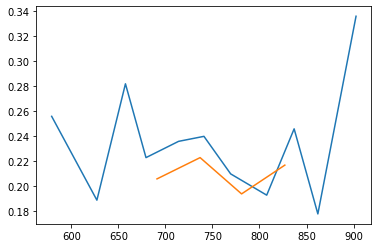

In [10]:
plt.plot(freqs[:11],obs[:11])
plt.plot(freqs[11:],obs[11:])

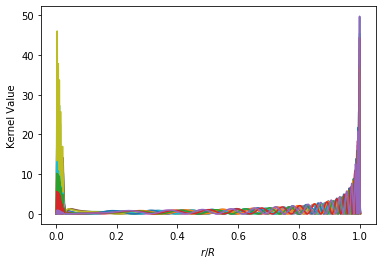

In [11]:
def load_kernels(size=4000):
    #max_l = 1 + max([int(path.split(".")[1].split("_")[0]) for path in paths])
    #max_n = 1 + max([int(path.split(".")[-1]) for path in paths])

    kerns = np.nan * np.ones((15, size))
    #os.chdir('kerns')
    for i in range(15):
            path = "l.{l:.0f}_n.{n:.0f}".format(l=list_pairs[i,0], n=list_pairs[i,1])
            kerns[i, :] = rot_k_table[path]
    os.chdir('..')
    return kerns

kern = load_kernels()





plt.plot(rot_k_table['x'],kern.T)
plt.xlabel(r'$r/R$')
plt.ylabel('Kernel Value')
plt.savefig('kernels_sun.pdf')

In [12]:
class Ordered(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

In [14]:
x = np.array(rot_k_table['x'])
N = 200
# the number of points you think you can afford in your GP
S = int(x.size / N) # approx sampling size.


#true_omega = true_omega3

X = x
x = np.linspace(0,1,N)
x_diffs = np.hstack([0, np.diff(x)])

l1_frequencies = np.array(freqs[:11])
l2_frequencies = np.array(freqs[11:])
#l3_frequencies = np.array(freqs[44:])

def frebin_1d(a):

    init_val = np.trapz(a,X)
    trans = frebin(a,dimensions = N)
    trans = trans/np.trapz(trans,x) * init_val

    return trans

def load_kernels(size=4000):
    #max_l = 1 + max([int(path.split(".")[1].split("_")[0]) for path in paths])
    #max_n = 1 + max([int(path.split(".")[-1]) for path in paths])

    kerns = np.nan * np.ones((15, size))
    #os.chdir('kerns')
    for i in range(15):
            path = "l.{l:.0f}_n.{n:.0f}".format(l=list_pairs[i,0], n=list_pairs[i,1])
            kerns[i, :] = rot_k_table[path]
    return kerns
    return kerns

kern = load_kernels()

kern_trans = np.apply_along_axis(frebin_1d, axis=1, arr=kern)

kern = kern_trans

#omega_trans = np.interp(x,X_rot,true_omega)
#true_omega = omega_trans

l_dict = {'1':[None,11],'2':[11,None]}



def pm_splittings(omega, l):

    
    l_bounds = l_dict[str(l)]
    
    lef = l_bounds[0]
    rig = l_bounds[1]
    
    area = 2*tt.dot(x_diffs,(omega*kern[lef:rig]).T)
    left_end = tt.dot(x_diffs[0],(omega[0]*kern[lef:rig,0]))
    right_end = tt.dot(x_diffs[-1],(omega[-1]*kern[lef:rig,-1]))
    area = tt.add(area,-left_end)
    area = tt.add(area,-right_end)
    print(betas[lef:rig].shape)
    return area/2 * betas[lef:rig]

def get_splittings(omega, l):
    
    l_bounds = l_dict[str(l)]
    
    lef = l_bounds[0]
    rig = l_bounds[1]
    
    area = np.trapz((omega * kern[lef:rig]),x)
    return area * betas[lef:rig]


#l1_splittings = np.array(obs[:10])*1e3
#l2_splittings = np.array(obs[11:])*1e3

e_l1_splittings = np.array(obs_table['e_delta'][:11])*1e3
e_l2_splittings = np.array(obs_table['e_delta'][11:])*1e3
#e_l3_splittings = np.array(err[44:])

l1_splittings = np.array(obs_table['delta'][:11])*1e3
l2_splittings = np.array(obs_table['delta'][11:])*1e3


#true_l1_splittings, true_l2_splittings,true_l3_splittings = get_splittings(true_omega,1),get_splittings(true_omega,2),get_splittings(true_omega,3)
#l1_splittings = true_l1_splittings + e_l1_splittings * np.random.normal(0, 1, size=true_l1_splittings.size)
#l2_splittings = true_l2_splittings + e_l2_splittings * np.random.normal(0, 1, size=true_l2_splittings.size)
#l3_splittings = true_l3_splittings + e_l3_splittings * np.random.normal(0, 1, size=true_l3_splittings.size)



#print(l1_frequencies.shape,l2_frequencies.shape,l1_splittings.shape,l2_splittings.shape,e_l1_splittings.shape,e_l2_splittings.shape) 

# A one dimensional column vector of inputs.
#X = x.reshape((-1, 1))

new_x = np.array(rot_k_table["x"])
N_latent = 200
S_latent = int(new_x.size / N_latent)



print(l1_splittings)

X = x
x = np.linspace(0,1,N)
x_diffs = np.hstack([0, np.diff(x)])



X_latent = x[:, None]

import theano.tensor as tt

class Heaviside(pm.gp.mean.Mean):

    def __init__(self, c, point = 0.5):
        pm.gp.mean.Mean.__init__(self)
        self.c1 = c[1]
        self.c2 = c[0]
        self.point = point

    def __call__(self, X):
        x=tt.alloc(self.c1,self.point)
        y=tt.alloc(self.c2,X.shape[0]-self.point)
        return tt.concatenate([x,y])

with pm.Model() as latent_gp_model:

    mus = pm.Uniform('y', 0,700, shape=2, 
              transform=Ordered(), testval=np.arange(2))
    
    #mu1 = pm.Uniform("mu_omega_1",0, 700)
    #mu2 = pm.Uniform("mu_omega_2",0, 700)
    point = pm.distributions.discrete.DiscreteUniform("point",20,50)
    #point = 50
    #lengthscale = 0.27
    #cov_func = eta_cov**2 * pm.gp.cov.Matern52(1, ls_cov)
    
    
    #lengthscale = 5
    #eta = 50
    #alpha = 0.7
    #cov_func = eta_cov**2 * pm.gp.cov.RatQuad(1, alpha_cov,ls =ls_cov)


    #cov_func = 75**2*pm.gp.cov.ExpQuad(1, ls=7e-1)
    #cov_func = pm.gp.cov.Matern52(1, ls=1e-1)
    
    
    gp = pm.gp.Latent(
        mean_func=Heaviside(c = mus,point = point),
        cov_func= pm.gp.cov.Constant(0)
    )



    # Place a GP prior over the function f.
    omega = gp.prior("omega", X=X_latent)

    l1_ = pm.Normal(
        'l1', 
        mu=pm_splittings(omega, 1), 
        sd=e_l1_splittings,
        observed=l1_splittings
    )

    l2_ = pm.Normal(
        'l2',
        mu=pm_splittings(omega, 2),
        sd=e_l2_splittings,
        observed=l2_splittings
    )


    trace = pm.sample(10000, tune=15000, chains=3)

[256. 189. 282. 223. 236. 240. 210. 193. 246. 178. 336.]
(11,)
(4,)


Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [omega_rotated_, y]
>Metropolis: [point]
Sampling 3 chains, 2,653 divergences: 100%|██████████| 75000/75000 [01:55<00:00, 648.38draws/s]
There were 1241 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7064407789157344, but should be close to 0.8. Try to increase the number of tuning steps.
There were 882 divergences after tuning. Increase `target_accept` or reparameterize.
There were 530 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

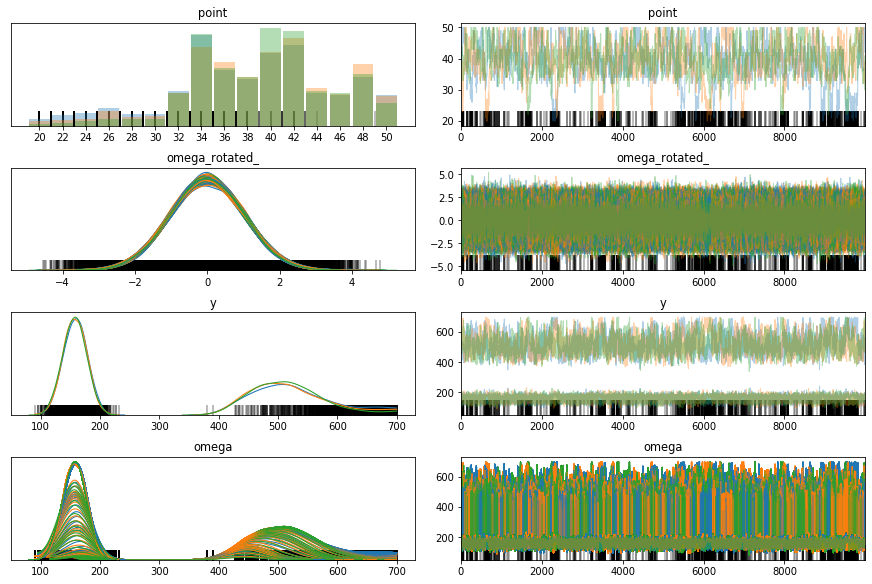

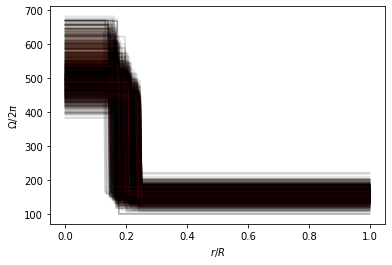

In [15]:
fig = pm.traceplot(trace)


N_samples = 1000
with latent_gp_model:
    pred_samples = pm.sample_ppc(trace, vars=(omega, l1_, l2_), samples=N_samples)

fig, ax = plt.subplots()
for sample in pred_samples["omega"]:
    ax.plot(x.T, sample, c='k', alpha=0.1)

#ax.plot(x, true_omega, c='tab:red', zorder=10)
ax.set_xlabel(r'$r/R$')
ax.set_ylabel(r'$\Omega/2\pi$')
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["omega"], x);




Text(0, 0.5, '$\\Omega/2\\pi$')

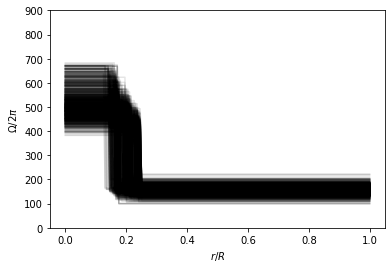

In [16]:
fig, ax = plt.subplots()
for sample in pred_samples["omega"]:
    #if np.min(np.diff((x**2*sample)**2)/np.diff(x))>0:
        ax.plot(x.T, sample, c='k', alpha=0.1)
plt.ylim(0,900)
#plt.plot(x.T,np.mean(pred_samples["omega"],axis = 0))
#plt.plot(X_rot,true_omega2)
plt.xlabel(r'$r/R$')
#plt.xscale('log')
plt.ylabel(r'$\Omega/2\pi$')

In [18]:
x = np.array(rot_k_table['x'])
N = 200
# the number of points you think you can afford in your GP
S = int(x.size / N) # approx sampling size.


#true_omega = true_omega3

X = x
x = np.linspace(0,1,N)
x_diffs = np.hstack([0, np.diff(x)])

l1_frequencies = np.array(freqs[:11])
l2_frequencies = np.array(freqs[11:])
#l3_frequencies = np.array(freqs[44:])

def frebin_1d(a):

    init_val = np.trapz(a,X)
    trans = frebin(a,dimensions = N)
    trans = trans/np.trapz(trans,x) * init_val

    return trans

def load_kernels(size=4000):
    #max_l = 1 + max([int(path.split(".")[1].split("_")[0]) for path in paths])
    #max_n = 1 + max([int(path.split(".")[-1]) for path in paths])

    kerns = np.nan * np.ones((15, size))
    #os.chdir('kerns')
    for i in range(15):
            path = "l.{l:.0f}_n.{n:.0f}".format(l=list_pairs[i,0], n=list_pairs[i,1])
            kerns[i, :] = rot_k_table[path]
    return kerns
    return kerns

kern = load_kernels()

kern_trans = np.apply_along_axis(frebin_1d, axis=1, arr=kern)

kern = kern_trans

#omega_trans = np.interp(x,X_rot,true_omega)
#true_omega = omega_trans

l_dict = {'1':[None,11],'2':[11,None]}



def pm_splittings(omega, l):

    
    l_bounds = l_dict[str(l)]
    
    lef = l_bounds[0]
    rig = l_bounds[1]
    
    area = 2*tt.dot(x_diffs,(omega*kern[lef:rig]).T)
    left_end = tt.dot(x_diffs[0],(omega[0]*kern[lef:rig,0]))
    right_end = tt.dot(x_diffs[-1],(omega[-1]*kern[lef:rig,-1]))
    area = tt.add(area,-left_end)
    area = tt.add(area,-right_end)
    print(betas[lef:rig].shape)
    return area/2 * betas[lef:rig]

def get_splittings(omega, l):
    
    l_bounds = l_dict[str(l)]
    
    lef = l_bounds[0]
    rig = l_bounds[1]
    
    area = np.trapz((omega * kern[lef:rig]),x)
    return area * betas[lef:rig]


#l1_splittings = np.array(obs[:10])*1e3
#l2_splittings = np.array(obs[11:])*1e3

e_l1_splittings = np.array(obs_table['e_delta'][:11])*1e3
e_l2_splittings = np.array(obs_table['e_delta'][11:])*1e3
#e_l3_splittings = np.array(err[44:])

l1_splittings = np.array(obs_table['delta'][:11])*1e3
l2_splittings = np.array(obs_table['delta'][11:])*1e3


#true_l1_splittings, true_l2_splittings,true_l3_splittings = get_splittings(true_omega,1),get_splittings(true_omega,2),get_splittings(true_omega,3)
#l1_splittings = true_l1_splittings + e_l1_splittings * np.random.normal(0, 1, size=true_l1_splittings.size)
#l2_splittings = true_l2_splittings + e_l2_splittings * np.random.normal(0, 1, size=true_l2_splittings.size)
#l3_splittings = true_l3_splittings + e_l3_splittings * np.random.normal(0, 1, size=true_l3_splittings.size)



#print(l1_frequencies.shape,l2_frequencies.shape,l1_splittings.shape,l2_splittings.shape,e_l1_splittings.shape,e_l2_splittings.shape) 

# A one dimensional column vector of inputs.
#X = x.reshape((-1, 1))

new_x = np.array(rot_k_table["x"])
N_latent = 200
S_latent = int(new_x.size / N_latent)



print(l1_splittings)

X = x
x = np.linspace(0,1,N)
x_diffs = np.hstack([0, np.diff(x)])



X_latent = x[:, None]

import theano.tensor as tt

class Heaviside(pm.gp.mean.Mean):

    def __init__(self, c, point = 0.5):
        pm.gp.mean.Mean.__init__(self)
        self.c1 = c[1]
        self.c2 = c[0]
        self.point = point

    def __call__(self, X):
        x=tt.alloc(self.c1,self.point)
        y=tt.alloc(self.c2,X.shape[0]-self.point)
        return tt.concatenate([x,y])

with pm.Model() as latent_gp_model:

    mus = pm.Uniform('y', 0,700, shape=2, 
              transform=Ordered(), testval=np.arange(2))
    
    #mu1 = pm.Uniform("mu_omega_1",0, 700)
    #mu2 = pm.Uniform("mu_omega_2",0, 700)
    point = pm.distributions.discrete.DiscreteUniform("point",36,39)
    #point = 38
    #lengthscale = 0.27
    #cov_func = eta_cov**2 * pm.gp.cov.Matern52(1, ls_cov)
    
    
    #lengthscale = 5
    #eta = 50
    #alpha = 0.7
    #cov_func = eta_cov**2 * pm.gp.cov.RatQuad(1, alpha_cov,ls =ls_cov)


    #cov_func = 75**2*pm.gp.cov.ExpQuad(1, ls=7e-1)
    #cov_func = pm.gp.cov.Matern52(1, ls=1e-1)
    
    
    gp = pm.gp.Latent(
        mean_func=Heaviside(c = mus,point = point),
        cov_func= pm.gp.cov.Constant(0)
    )



    # Place a GP prior over the function f.
    omega = gp.prior("omega", X=X_latent)

    l1_ = pm.Normal(
        'l1', 
        mu=pm_splittings(omega, 1), 
        sd=e_l1_splittings,
        observed=l1_splittings
    )

    l2_ = pm.Normal(
        'l2',
        mu=pm_splittings(omega, 2),
        sd=e_l2_splittings,
        observed=l2_splittings
    )


    trace = pm.sample(10000, tune=15000, chains=3)

[256. 189. 282. 223. 236. 240. 210. 193. 246. 178. 336.]
(11,)
(4,)


Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [omega_rotated_, y]
>Metropolis: [point]
Sampling 3 chains, 29 divergences:  67%|██████▋   | 50000/75000 [01:58<00:59, 421.44draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
HMMMMM 

/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/tawil10/.local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

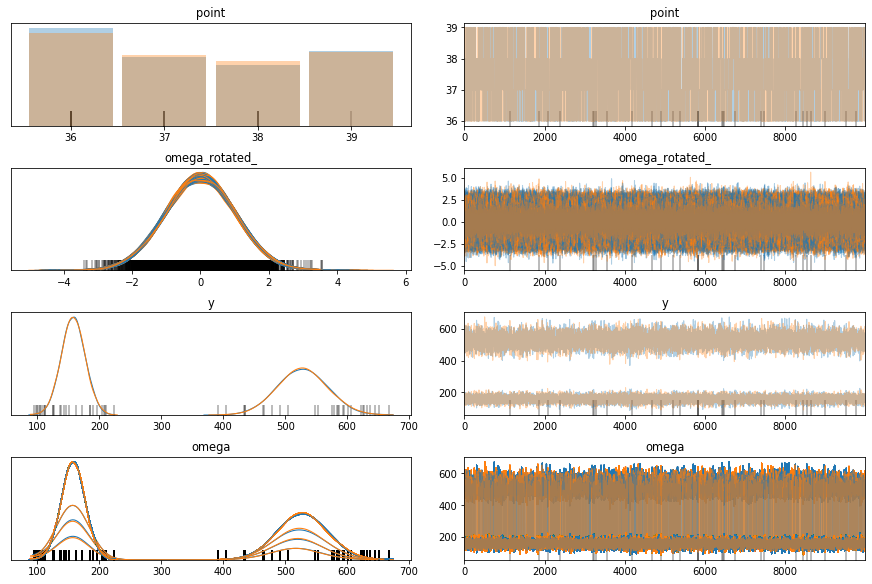

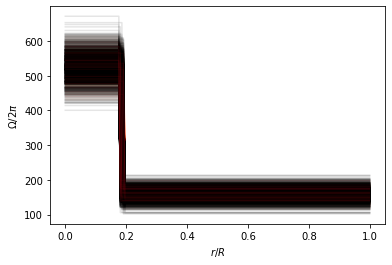

In [19]:
fig = pm.traceplot(trace)


N_samples = 1000
with latent_gp_model:
    pred_samples = pm.sample_ppc(trace, vars=(omega, l1_, l2_), samples=N_samples)

fig, ax = plt.subplots()
for sample in pred_samples["omega"]:
    ax.plot(x.T, sample, c='k', alpha=0.1)

#ax.plot(x, true_omega, c='tab:red', zorder=10)
ax.set_xlabel(r'$r/R$')
ax.set_ylabel(r'$\Omega/2\pi$')
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["omega"], x);




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f865c6790>,
      dtype=object)

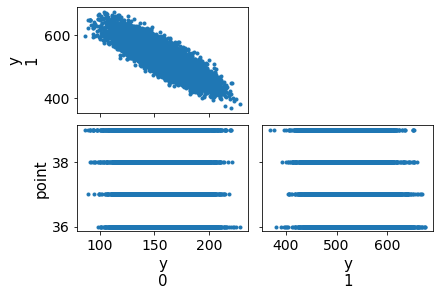

In [20]:
pm.plot_pair(trace,['y','point'])